In [2]:
import numpy as np
import cmath
import math
from math import lgamma,exp
#from sklearn.preprocessing import normalize
from scipy.constants import epsilon_0 as ε_0, c, pi as π, e, hbar as ℏ
eV = e
from scipy.special import lpmn, lpmv, sph_jn, sph_yn, poch
from scipy.misc import factorial
from numpy import newaxis as ň
import sympy.physics.wigner as sw
debye = 3.33564e-30
from math import sin,cos
import cmath

I = np.identity(3)

In [11]:
vc.gaunt_xu(7,42,-15,44,q_max(7,42,-15,44))[0][35]

5.7535871259803721e-13

In [3]:
from py_gmm.gmm import vec_trans as vc

In [3]:
vc.gaunt_xu(-15,55,-58,72,27)

(array([  2.64656585e+17,  -9.02060942e+17,   1.26120695e+18,
         -9.08154188e+17,   3.32877338e+17,  -3.99902372e+16,
         -9.37042460e+15,   1.93795427e+15,   4.15147444e+14,
         -4.50334569e+13,  -1.87310470e+13,  -6.89282471e+11,
          4.70652220e+11,   8.36238653e+10,   3.33171146e+08,
         -1.79374160e+09,  -2.62337431e+08,  -5.94969041e+06,
          3.03619342e+06,   4.52389705e+05,   2.13275693e+04,
         -1.46829323e+03,  -2.69213511e+02,  -1.39717873e+01,
          9.60086347e-03,   2.93425224e-02,   8.10789281e-04,
         -5.91092804e-06]), 0)

In [18]:
lpmn(-4,4,cos(0.5))

(array([[  1.00000000e+00,   8.77582562e-01,   6.55226729e-01,
           3.73304212e-01,   8.18891693e-02],
        [  0.00000000e+00,   2.39712769e-01,   2.10367746e-01,
           1.70840640e-01,   1.25750374e-01],
        [  0.00000000e+00,   0.00000000e+00,   2.87311059e-02,
           2.52139175e-02,   2.10266591e-02],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           2.29573765e-03,   2.01469933e-03],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   1.37579408e-04]]),
 array([[  0.00000000e+00,   1.00000000e+00,   2.63274769e+00,
           4.27613365e+00,   5.24587717e+00],
        [  0.00000000e+00,  -9.15243861e-01,  -5.63489283e-01,
          -1.26364813e-01,   3.09318830e-01],
        [  0.00000000e+00,   0.00000000e+00,  -2.19395640e-01,
          -1.63806682e-01,  -1.01730692e-01],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          -2.62959683e-02,  -2.07811456e-02],
        [  0.0000

In [24]:
vc.legendre(0,4,-1,1,0.5)
#vc.pi_mn(4,0.5)

(array([ 0.        , -0.23971277, -0.21036775, -0.17084064, -0.12575037]), 0)

In [8]:
sw.gaunt(15,16,17,4,5,-9).evalf()

-0.0648286110541008

In [4]:
# NOT REALLY USING THIS NOW; JUST FOR BENCHMARKS
# from https://raw.githubusercontent.com/michael-hartmann/gaunt/master/gaunt.py

from __future__ import division
from math import lgamma,exp

def gaunt_a0(n,nu,m,mu):
    # eq. (20)
    return exp( lgamma(2*n+1)-lgamma(n+1)+lgamma(2*nu+1)-lgamma(1+nu)+lgamma(n+nu+1)-lgamma(2*n+2*nu+1) + lgamma(1+n+nu-m-mu)-lgamma(1+n-m)-lgamma(1+nu-mu) )


def gaunt_hartmann(n,nu,m,mu):
    """
    Determine Gaunt coefficients a(m, n, mu, nu, p) for m, n, mu and nu fixed.
    These coefficients can be used to express the product of two associated
    Legendre polynomials:

    P_n^m(x)*P_{nu}^{mu}(x) = a0 sum_{q=0}^{qmax} aq_tilde P_{n+nu-2q}^(m+mu)(x)
    
    Returns: qmax, a0, aq_tilde
    qmax is the upper bound of summation, a0 is the prefactor and aq_tilde is a
    list of normalized Gaunt coefficients.

    See [1] for more information, especially chapter 3. There is a brief
    outline how to calculate Gaunt coefficients at the end of the chapter.

    Ref.: [1] Y.-L. Xu, J. Comp. Appl. Math. 85, 53 (1997)
    """

    # eq. (28)
    Ap = lambda p:p*(p-1)*(m-mu)-(m+mu)*(n-nu)*(n+nu+1)

    # eq. (3)
    alpha = lambda p: ((p**2-(n+nu+1)**2)*(p**2-(n-nu)**2))/(4*p**2-1)

    # eq. (24)
    qmax = min(n,nu,(n+nu-abs(m+mu))//2)

    a0 = gaunt_a0(n,nu,m,mu)

    n4 = n+nu-m-mu
    a_tilde = [0]*(qmax+1)

    a_tilde[0] = 1
    if qmax == 0:
        return qmax,a0,a_tilde

    # eq. (29)
    a_tilde[1] = (n+nu-1.5)*(1-(2*n+2*nu-1)/(n4*(n4-1))*((m-n)*(m-n+1)/(2*n-1)+(mu-nu)*(mu-nu+1)/(2*nu-1)))
    if qmax == 1:
        return qmax,a0,a_tilde

    # eq. (35)
    a_tilde[2] = (2*n+2*nu-1)*(2*n+2*nu-7)/4*( (2*n+2*nu-3)/(n4*(n4-1)) * ( (2*n+2*nu-5)/(2*(n4-2)*(n4-3)) \
                * ( (m-n)*(m-n+1)*(m-n+2)*(m-n+3)/((2*n-1)*(2*n-3)) \
                + 2*(m-n)*(m-n+1)*(mu-nu)*(mu-nu+1)/((2*n-1)*(2*nu-1)) \
                + (mu-nu)*(mu-nu+1)*(mu-nu+2)*(mu-nu+3)/((2*nu-1)*(2*nu-3)) ) - (m-n)*(m-n+1)/(2*n-1) \
                - (mu-nu)*(mu-nu+1)/(2*nu-1) ) +0.5)


    for q in range(3,qmax+1):
        p = n+nu-2*q
        p1 = p-m-mu
        p2 = p+m+mu

        if Ap(p+4) != 0:
            # eqs. (26), (27)
            c0 = (p+2)*(p+3)*(p1+1)*(p1+2)*Ap(p+4)*alpha(p+1)
            c1 = Ap(p+2)*Ap(p+3)*Ap(p+4) \
               + (p+1)*(p+3)*(p1+2)*(p2+2)*Ap(p+4)*alpha(p+2) \
               + (p+2)*(p+4)*(p1+3)*(p2+3)*Ap(p+2)*alpha(p+3)
            c2 = -(p+2)*(p+3)*(p2+3)*(p2+4)*Ap(p+2)*alpha(p+4)
            a_tilde[q] = (c1*a_tilde[q-1] + c2*a_tilde[q-2])/c0
        else:
            if Ap(p+6) == 0:
                # eq. (30)
                a_tilde[q] = (p+1)*(p2+2)*alpha(p+2)*a_tilde[q-1] / ((p+2)*(p1+1)*alpha(p+1))
            else:
                # eq. (32), (33)
                c0 = (p+2)*(p+3)*(p+5)*(p1+1)*(p1+2)*(p1+4)*Ap(p+6)*alpha(p+1)
                c1 = (p+5)*(p1+4)*Ap(p+6)*(Ap(p+2)*Ap(p+3)+(p+1)*(p+3)*(p1+2)*(p2+2)*alpha(p+2))
                c2 = (p+2)*(p2+3)*Ap(p+2)*(Ap(p+5)*Ap(p+6)+(p+4)*(p+6)*(p1+5)*(p2+5)*alpha(p+5))
                c3 = -(p+2)*(p+4)*(p+5)*(p2+3)*(p2+5)*(p2+6)*Ap(p+2)*alpha(p+6)
                a_tilde[q] = (c1*a_tilde[q-1] + c2*a_tilde[q-2] + c3*a_tilde[q-3])/c0

    return qmax,a0,a_tilde

In [5]:
def q_max(m,n,μ,ν):
    return min(n,ν,(n+ν-abs(m+μ))/2)
    
# returns array with indices corresponding to q
# argument q does nothing for now
def a_q(m,n,μ,ν,q = None):
    qm=q_max(m,n,μ,ν)
    res, err= vc.gaunt_xu(m,n,μ,ν,qm)
    if(err):
        raise ValueError('Something bad in the fortran subroutine gaunt_xu happened')
    return res
    

In [6]:
def _sph_z_1(n,z):
    return sph_jn(n,z)[0]
def _sph_z_2(n,z):
    return sph_yn(n,z)[0]
def _sph_z_3(n,z):
    return (sph_jn(n,z)[0] + 1j*sph_yn(n,z)[0])
def _sph_z_4(n,z):
    return (sph_jn(n,z)[0] - 1j*sph_yn(n,z)[0])
_sph_z = [_sph_z_1,_sph_z_2,_sph_z_3,_sph_z_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def sph_zn(n, z, J=1):
    return _sph_z[J-1](n=n,z=z)
    

In [14]:
# All arguments are single numbers (for now)
# ZDE VYCHÁZEJÍ DIVNÁ ZNAMÉNKA
def A(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(lgamma(2*n+1)-lgamma(n+2)+lgamma(2*ν+3)-lgamma(ν+2) 
                +lgamma(n+ν+m-μ+1)-lgamma(n-m+1)-lgamma(ν+μ+1)
                +lgamma(n+ν+1) - lgamma(2*(n+ν)+1))
    presum = exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**μ * 1j**(ν+n) / (4*n)
    qmax = math.floor(q_max(-m,n,μ,ν)) #nemá tu být +m?
    q = np.arange(qmax+1, dtype=int)
    # N.B. -m !!!!!!
    a1q = a_q(-m,n,μ,ν) # there is redundant calc. of qmax
    ã1q = a1q / a1q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp = sph_zn(n+ν,kdlj,J)[p]
    Pp = lpmv(μ-m,p,math.cos(θlj))
    summandq = (n*(n+1) + ν*(ν+1) - p*(p+1)) * (-1)**q * ã1q * zp * Pp
    return presum * np.sum(summandq)
    
# ZDE OPĚT JINAK ZNAMÉNKA než v Xu (J. comp. phys 127, 285)
def B(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(lgamma(2*n+3)-lgamma(n+2)+lgamma(2*ν+3)-lgamma(ν+2) 
                +lgamma(n+ν+m-μ+2)-lgamma(n-m+1)-lgamma(ν+μ+1)
                +lgamma(n+ν+2) - lgamma(2*(n+ν)+3))
    presum = exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**μ * 1j**(ν+n+1) / (
        (4*n)*(n+1)*(n+m+1))
    Qmax = math.floor(q_max(-m,n+1,μ,ν))
    q = np.arange(Qmax+1, dtype=int)
    if (μ == ν): # it would disappear in the sum because of the factor (ν-μ) anyway
        ã2q = 0
    else:
        a2q = a_q(-m-1,n+1,μ+1,ν)
        ã2q = a2q / a2q[0]
    a3q = a_q(-m,n+1,μ,ν)
    ã3q = a3q / a3q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp_ = sph_zn(n+1+ν,kdlj,J)[p+1] # je ta +1 správně?
    Pp_ = lpmv(μ-m,p+1,math.cos(θlj))
    summandq = ((2*(n+1)*(ν-μ)*ã2q
                 -(-ν*(ν+1) - n*(n+3) - 2*μ*(n+1)+p*(p+3))* ã3q)
                *(-1)**q * zp_ * Pp_)
    return presum * np.sum(summandq)
    
    

In [40]:
qmax, a0, aq_tilde = gaunt_hartmann(55,72,-15,-58)

In [8]:
a_q(10,20,3,22)

array([  6.73486067e-06,  -1.33283793e-05,  -1.91678244e-05,
        -9.42156059e-06,   3.21083421e-05,   1.34283528e-04,
         3.30781139e-04,   5.90352646e-04,   4.63514691e-04,
        -2.47047126e-03,  -1.90019974e-02,  -9.18202665e-02,
        -3.33697514e-01,   1.77143838e-01,   4.50755048e+01])

In [12]:
a0*np.array(aq_tilde)

array([  2.64656585e+17,  -9.02060942e+17,   1.26120695e+18,
        -9.08154188e+17,   3.32877338e+17,  -3.99902372e+16,
        -9.37042460e+15,   1.93795427e+15,   4.15147444e+14,
        -4.50334569e+13,  -1.87310470e+13,  -6.89282471e+11,
         4.70652220e+11,   8.36238653e+10,   3.33171146e+08,
        -1.79374160e+09,  -2.62337431e+08,  -5.94969041e+06,
         3.03619342e+06,   4.52389705e+05,   2.13275693e+04,
        -1.46829323e+03,  -2.69213511e+02,  -1.39717873e+01,
         9.60086347e-03,   2.93425224e-02,   8.10789281e-04,
        -5.91092804e-06])

In [9]:
A(41,45,-42,45,2.0,0.5,0.5,False,3)

(1.6418071489948327e+235+2.1185245649284814e+235j)

In [15]:
B(-1,1,1,1,2.0,0.5,0.5,False,3)

(-0+0j)

In [36]:
sph_z(4,6,4)

array([-0.04656925+0.16002838j, -0.16778992-0.01989785j,
       -0.03732571-0.16997731j,  0.13668516-0.1217499j ,
        0.19679174+0.02793575j])

2.652528598121911e+32

In [38]:
factorial(30)

array(2.652528598121911e+32)

In [61]:
lpmv(2,np.array([4,5,6]),math.cos(0.5))

array([  7.56959726,  13.87749947,  20.24449652])

In [56]:
lpmn(2,5,math.cos(0.5))

(array([[  1.        ,   0.87758256,   0.65522673,   0.37330421,
           0.08188917,  -0.16928726],
        [  0.        ,  -0.47942554,  -1.26220648,  -2.05008768,
          -2.51500749,  -2.40342551],
        [  0.        ,   0.        ,   0.68954654,   3.0256701 ,
           7.56959726,  13.87749947]]),
 array([[  0.        ,   1.        ,   2.63274769,   4.27613365,
           5.24587717,   5.01313617],
        [  0.        ,   1.83048772,   3.3809357 ,   1.51637775,
          -6.18637661, -19.76961556],
        [  0.        ,   0.        ,  -5.26549537, -19.65680188,
         -36.62304916, -34.39685236]]))

In [106]:
m=-15
n=55
μ=-58
ν=72
poch(n+2,n-1)*poch(ν+3,ν+2)/poch(n+ν+1,n+ν)*float(math.factorial(n+ν+m-μ))/math.factorial(n-m)/math.factorial(ν+m)

5.916745964440022e+95

In [98]:
np.exp(1030)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


inf

# The VSWF basis

In [439]:
# Quick and dirty cell, delete!

# Now with the derivatives included
def _sph_zn_1(n,z):
    return sph_jn(n,z)
def _sph_zn_2(n,z):
    return sph_yn(n,z)
def _sph_zn_3(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] + 1j*besy[0],besj[1] + 1j*besy[1])
def _sph_zn_4(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] - 1j*besy[0],besj[1] - 1j*besy[1])
_sph_zn = [_sph_zn_1,_sph_zn_2,_sph_zn_3,_sph_zn_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def zn(n, z, J=1):
    return _sph_zn[J-1](n=n,z=z)

def SVWF_base(sph_pos, ms, ns, coord_axis = -1, J=1):
    mans = np.array([np.abs(ms), ns]).T
    nmax = np.max(ns)
    if (np.sum(np.abs(ms) > ns)):
        raise ValueError("|m| > n")
    pshape = sph_pos.shape
    M = np.empty(ms.shape+pshape,dtype=complex)
    N = np.empty(ms.shape+pshape,dtype=complex)
    # TODO vectorize
    for li in np.ndindex(pshape[:coord_axis]):
        for ri in np.ndindex(pshape[coord_axis:][1:]):
            r = sph_pos[li+(0,)+ri]
            θ = sph_pos[li+(1,)+ri]
            if (θ == 0): # Dirty stuff
                θ = 1e-7
            φ = sph_pos[li+(2,)+ri]
            cosθ = cos(θ)
            sinθ = sin(θ)
            sinφ = sin(φ)
            cosφ = cos(φ)
            ř = np.array([sinθ*cosφ,sinθ*sinφ,cosθ]) # je to dobře?
            θ̂ = np.array([cosθ*cosφ,cosθ*sinφ,-sinθ])
            φ̂ = np.array([-sinφ, cosφ, 0])
            m_plus = np.arange(nmax+1)
            m_minus = - m_plus
            eimφ_plus = np.exp(1j*m_plus*φ)
            eimφ_minus = np.exp(1j*m_minus*φ)
            Pmn_plus = lpmn(nmax,nmax,cosθ)
            Pmn_minus = lpmn(-nmax,nmax,cosθ)
            τ_plus = -sinθ * Pmn_plus[1]
            τ_minus = -sinθ * Pmn_plus[1]
            π_plus = Pmn_plus[0] * m_plus[:,ň] / sinθ
            π_minus = Pmn_minus[0] * m_minus[:,ň] / sinθ
            z_n, zder_n = zn(nmax, r, J)
            print(z_n, zder_n)
            # nové indexy v pořadí m, n, vektor
            M_plus = (θ̂[ň,ň,:] * 1j * π_plus[:,:,ň] 
                      - φ̂[ň,ň,:] * τ_plus[:,:,ň]) * (
                      z_n[ň,:,ň] * eimφ_plus[:,ň,ň])
            M_minus = (θ̂[ň,ň,:] * 1j * π_minus[:,:,ň] 
                      - φ̂[ň,ň,:] * τ_minus[:,:,ň]) * (
                      z_n[ň,:,ň] * eimφ_minus[:,ň,ň])
            N_plus = ř[ň,ň,:]*(n*(n+1))[ň,:,ň]*Pmn_plus[:,:,ň]*(
                z_n[ň,:,ň]/r + zder_n[ň,:,ň]) * eimφ_plus[:,ň,ň] + (
                θ̂[ň,ň,:] * τ_plus[:,:,ň] + φ̂[ň,ň,:] * 1j * 
                π_plus[:,:,ň] ) * (z_n[ň,:,ň]/r + zder_n[ň,:,ň]) *(
                eimφ_plus[:,ň,ň])
            N_minus = ř[ň,ň,:]*(n*(n+1))[ň,:,ň]*Pmn_minus[:,:,ň]*(
                z_n[ň,:,ň]/r + zder_n[ň,:,ň]) * eimφ_minus[:,ň,ň] + (
                θ̂[ň,ň,:] * τ_minus[:,:,ň] + φ̂[ň,ň,:] * 1j * 
                π_minus[:,:,ň] ) * (z_n[ň,:,ň]/r + zder_n[ň,:,ň]) *(
                eimφ_minus[:,ň,ň])
            # FIXME assuming that ms, ns are flat...
            # [ms index, vektor, pos
            plusm = np.greater_equal(ms, 0)
            minusm = np.logical_not(plusm)
            M[:,li,:,ri] = plusm[:,ň] * M_plus[mans[:],:] + minusm[:,ň] * M_minus[mans[:],:]
            N[:,li,:,ri] = plusm[:,ň] * N_plus[mans[:],:] + minusm[:,ň] * N_minus[mans[:],:]
    return(M,N)
    

def τ(m,n,θ):
    return -sin(θ)*lpmn(m,n,cos(θ))[1][m,n]

def Π(m,n,θ):
    return (m/sin(θ))*lpmv(m,n,cos(θ))

def svw_M(m, n, k, r, θ, φ, J=1):
    # FIXME the implementation is _wrong_ very near z axis
    # and the problem remains in the derivatives of Legendre polynomials
    # k is single scalar, r is single 3D vector
    kr = k*r
    cosθ = cos(θ)
    sinθ = sin(θ)
    sinφ = sin(φ)
    cosφ = cos(φ)
    θ̂ = np.array([cosθ*cosφ,cosθ*sinφ,-sinθ])
    φ̂ = np.array([-sinφ, cosφ, 0])
    
    return ((1j * θ̂  * Π(m,n,θ) - φ̂ *τ(m,n,θ))
            * zn(n, kr, J)[0][n] * cmath.exp(1j*m*φ))

def svw_N(m, n, k, r, θ, φ, J=1):
    kr = k*r
    cosθ = cos(θ)
    sinθ = sin(θ)
    sinφ = sin(φ)
    cosφ = cos(φ)
    eimφ = cmath.exp(1j*m*φ)
    ř = np.array([sinθ*cosφ,sinθ*sinφ,cosθ]) # je to dobře?
    θ̂ = np.array([cosθ*cosφ,cosθ*sinφ,-sinθ])
    φ̂ = np.array([-sinφ, cosφ, 0])
    eimφ = cmath.exp(1j*m*φ)
    zz = zn(n, kr, J)
    radpart = n*(n+1)*lpmv(m,n,cosθ)*(zz[0][n]/kr)*eimφ*ř
    angpart = (θ̂ *τ(m,n,θ) + 1j*φ̂ *Π(m,n,θ)) * (
      zz[0][n]/kr + zz[1][n]) * eimφ
    return (radpart + angpart)

def spherical_vector_waves(nmax, k, r):
    # FIXME the implementation is _wrong_ very near z axis
    # and the problem remains in the derivatives of Legendre polynomials
    # k is single scalar, r is single 3D vector
    r.shape = (3) # FIXME do proper check
    ρ = np.linalg.norm(r)
    r̂ = r/ρ
    cosθ = r̂[2]
    sinθ = np.sqrt(1-cosθ*cosθ) # FIXME np->math
    cosφ = r̂[0]/sinθ if sinθ else 0 # avoid zero division here
    sinφ = r̂[1]/sinθ if sinθ else 1
    φ = np.arctan2(sinφ,cosφ)
    # TODO can those be views so I don't have to write the indices
    # explicitly?
    m = np.arange(nmax+1)
    n = m
    sinmφ = np.sin(m*φ)
    cosmφ = np.cos(m*φ)
    θ̂ = np.array([cosθ*cosφ,cosθ*sinφ,-sinθ])
    φ̂ = np.array([-sinφ, cosφ, 0])
    jnkr2 = sph_jn(nmax, k*ρ)
    # scipy.special.lpmn is for real arguments (see also clpmn)
    # + derivatives
    # m's are non-negative, cf. Bohren&Huffman (4.23)
    Pmn2 = lpmn(nmax, nmax, cosθ)
    
    # FIXME this is _wrong_ very near z axis – but it avoids nan 
    # and should give correct result exactly on z axis
    mdsinθ = m/(sinθ if sinθ else 1)
    
    Memn = (-mdsinθ[:,nx] * jnkr2[0][nx,:] * 
         Pmn2[0] * sinmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         + sinθ * jnkr2[0][nx,:] * Pmn2[1] * cosmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Momn = (mdsinθ[:,nx] * jnkr2[0][nx,:] * 
         Pmn2[0] * cosmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         + sinθ * jnkr2[0][nx,:] * Pmn2[1] * sinmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Npfac = jnkr2[0]/(k*ρ) + jnkr2[1]
    Nemn = (((n*(n+1)/(k*ρ))*jnkr2[0])[nx,:]
         * Pmn2[0] * cosmφ[:,nx])[:,:,nx] * r̂[nx,nx,:] + ( Npfac[nx,:] *
         (-sinθ) * Pmn2[1] * cosmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         Npfac[nx,:] * (-mdsinθ)[:,nx] * Pmn2[0] * sinmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Nomn = (((n*(n+1)/(k*ρ))*jnkr2[0])[nx,:]
         * Pmn2[0] * sinmφ[:,nx])[:,:,nx] * r̂[nx,nx,:] + ( Npfac[nx,:] *
         (-sinθ) * Pmn2[1] * sinmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         Npfac[nx,:] * mdsinθ[:,nx] * Pmn2[0] * cosmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    return (Memn, Momn, Nemn, Nomn)


#TODO: test against my old code (electroballz)!
def mie_reflection_coefficients(a, nmax, ε_m, ε_b, ω):
    # permittivities are relative!
    # cf. PRB 85, 075303, Appendix
    # assuming unit rel. permeability
    # for general permeability, cf. van Vlack's
    # dissertation, pp. 41–42
    #print("a, nmax, ε_m, ε_b, ω",a, nmax, ε_m, ε_b, ω)
    k_m = cmath.sqrt(ε_m) * ω / c
    x_m = k_m * a
    k_b = cmath.sqrt(ε_b) * ω / c
    x_b = k_b * a
    #print("k_m, x_m,k_b,x_b",k_m, x_m,k_b,x_b)
    jnka2_m = sph_jn(nmax, x_m)
    jnka2_b = sph_jn(nmax, x_b)
    ynka2_m = sph_yn(nmax, x_m)
    ynka2_b = sph_yn(nmax, x_b)
    #print("bessel funs",jnka2_m, jnka2_b, ynka2_m, ynka2_b)
    τ_m = jnka2_m[0]
    τ_b = jnka2_b[0]
    κ_m = τ_m + 1j * ynka2_m[0]
    κ_b = τ_b + 1j * ynka2_b[0]
    dτ_m = τ_m / x_m + jnka2_m[1]
    dτ_b = τ_b / x_b + jnka2_b[1]
    dκ_m = κ_m / x_m + jnka2_m[1] + 1j * ynka2_m[1]
    dκ_b = κ_b / x_b + jnka2_b[1] + 1j * ynka2_b[1]
    #print("bessel funs processed",τ_m,τ_b,κ_m,κ_b,dτ_m,dτ_b,dκ_m,dκ_b)
    RH = (k_m*dτ_m*τ_b - k_b*dτ_b*τ_m) / (k_m*dτ_m*κ_b - k_b*dκ_b*τ_m)
    RV = (k_m*τ_m*dτ_b - k_b*τ_b*dτ_m) / (k_m*τ_m*dκ_b - k_b*κ_b*dτ_m)
    return (RH, RV)

In [330]:
svw_M(m=1, n=1, k=1, r=1, θ=1, φ=1, J=1)

array([ -4.16333634e-17 -1.62722132e-01j,
         1.62722132e-01 +4.16333634e-17j,  -2.13249536e-01 +1.36925952e-01j])

In [356]:
# Coordinate transforms for arrays of "arbitrary" shape
def cart2sph(cart,axis=-1):
    if (cart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [x, y, z] = np.split(cart,3,axis=axis)
    r = np.linalg.norm(cart,axis=axis,keepdims=True)
    r_zero = np.logical_not(r)
    θ = np.arccos(z/(r+r_zero))
    φ = np.arctan2(y,x) # arctan2 handles zeroes correctly itself
    return np.concatenate((r,θ,φ),axis=axis)

def sph2cart(sph, axis=-1):
    if (sph.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    x = r * sinθ * np.cos(φ)
    y = r * sinθ * np.sin(φ)
    z = r * np.cos(θ)
    return np.concatenate((x,y,z),axis=axis)

# Auxillary function for retrieving the "meshgrid-like" indices; inc. nmax
def mnindex(nmax):
    nelems = nmax * nmax + 2*nmax
    n = np.arange(1,nmax+1,1,dtype=int)
    m = np.arange(-nmax,nmax+1,1,dtype=int)
    m, n = np.meshgrid(m, n)
    valid = abs(m) <= n
    return (m[valid],n[valid])   

In [332]:
cart2sph(sph2cart(np.array([1,π/2,0])))

array([ 1.        ,  1.57079633,  0.        ])

In [333]:
%matplotlib inline
import matplotlib.pyplot as plt

## Test of the basis functions

In [413]:
def xuE(m,n,μ,ν):
    fak1= 1j**(ν-n) * (2*ν+1)/(2*n+1)
    fak2 = math.exp(lgamma(n+m+1)+lgamma(ν-μ+1)-lgamma(n-m+1)-lgamma(ν+μ+1))
    return fak1*fak2

(1, 60, 40)
(1, 60, 40)
max|Re Vx| = 5.33744716713e-17 ; max|Re Vy| = 0.435835636107 ; max|Re Vz| = 0.0
max|Im Vx| = 7.74223604915e-15 ; max|Im Vy| = 63.2201550238 ; max|Im Vz| = 0.0


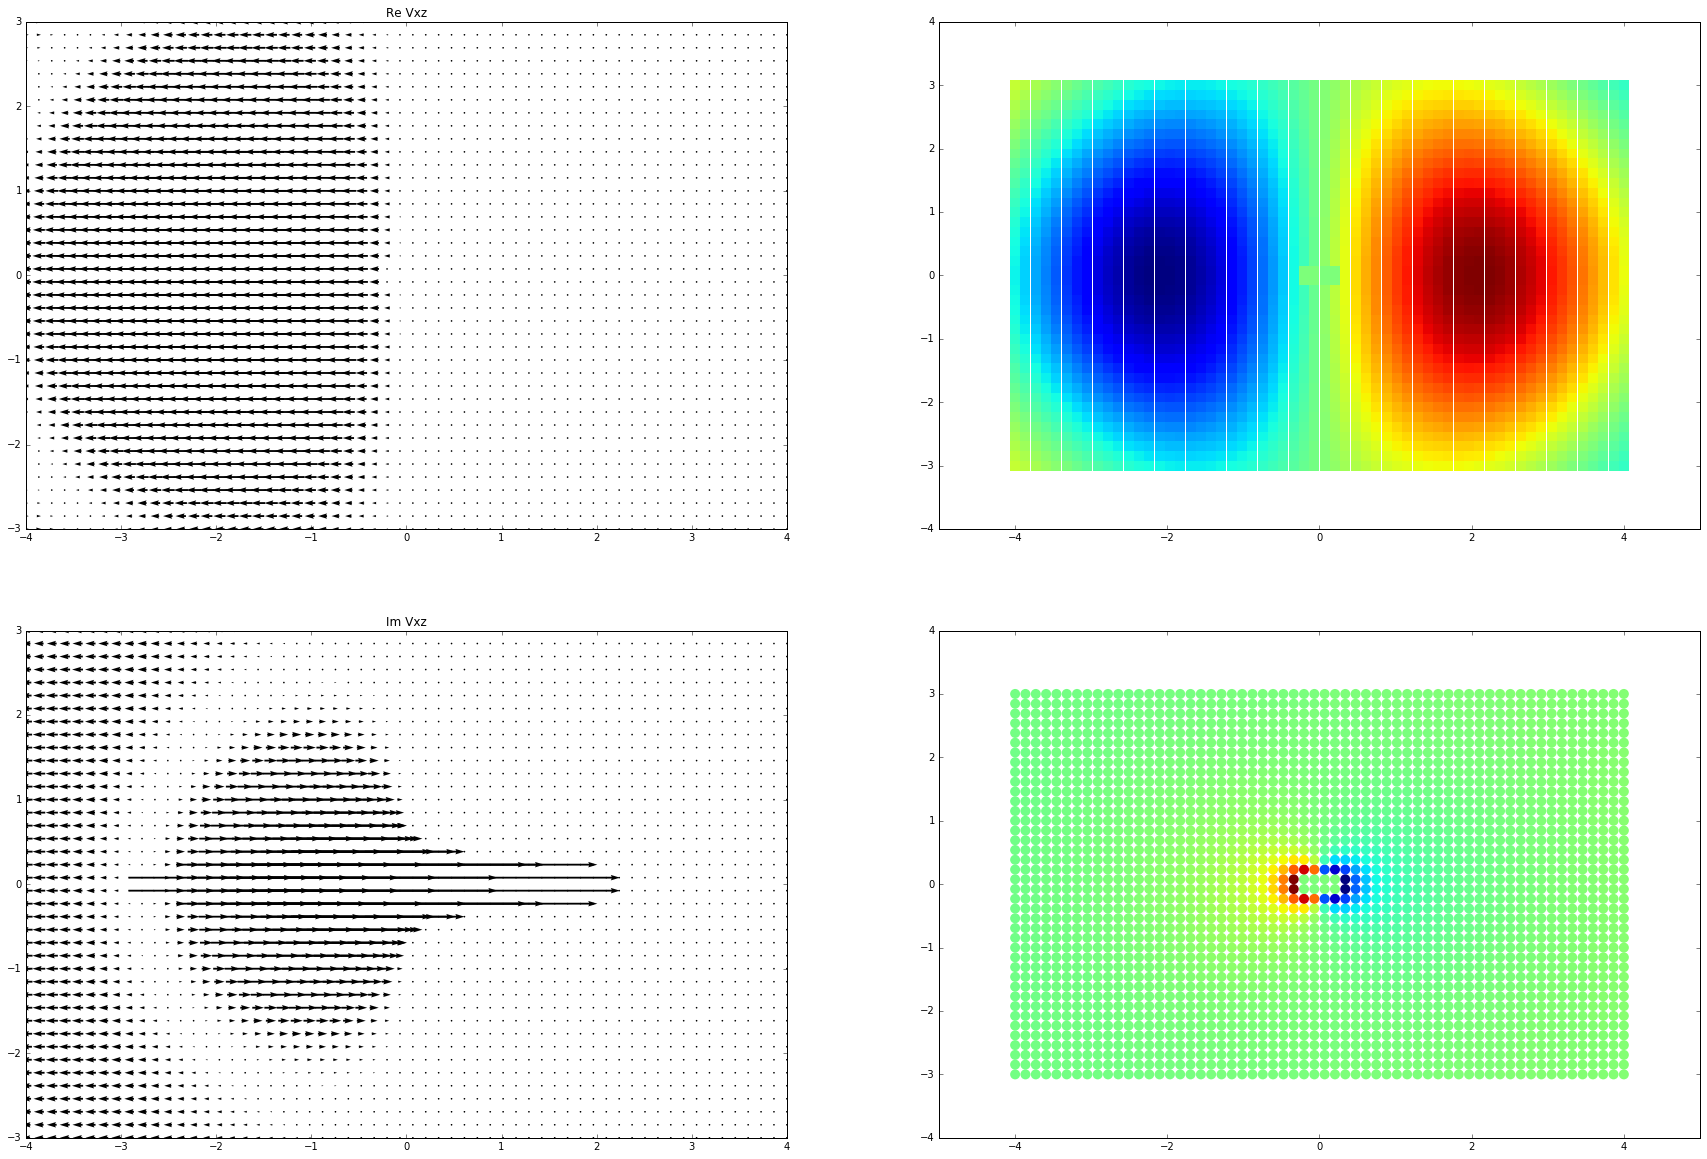

In [407]:
m=0
n=1
k=1
J=3

x = np.linspace(-4,4,60)
y = 0
z = np.linspace(-3,3,40)
x,y,z = np.meshgrid(x,y,z)


# TODO udělat _funkce_ na řezy vln
Nrθ = np.empty(x.shape+(3,),dtype=complex)
cart = np.stack((x,y,z),axis=-1)
sph = cart2sph(cart,axis=-1)
print(x.shape)
for i in np.ndindex(x.shape):
        Nrθ[i] = svw_M(m, n, k, sph[i+(0,)], sph[i+(1,)], sph[i+(2,)], J=J)
print(u.shape)
print("max|Re Vx| =",np.max(np.abs(np.real(Nrθ[...,0]))),
      "; max|Re Vy| =",np.max(np.abs(np.real(Nrθ[...,1]))),
      "; max|Re Vz| =",np.max(np.abs(np.real(Nrθ[...,2]))))
print("max|Im Vx| =",np.max(np.abs(np.imag(Nrθ[...,0]))),
      "; max|Im Vy| =",np.max(np.abs(np.imag(Nrθ[...,1]))),
      "; max|Im Vz| =",np.max(np.abs(np.imag(Nrθ[...,2]))))
Nrθ = Nrθ * (np.amax(np.abs(Nrθ), axis=-1, keepdims=True) < 20) # filter out the extremely from the plot
f, axarr = plt.subplots(2, 2, figsize=(30,20))
#plt.figure(figsize=(6, 4))
axarr[0,0].quiver(x.flatten(),z.flatten(),np.real(Nrθ[...,0]).flatten(),np.real(Nrθ[...,2]).flatten(),pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(x.flatten(),z.flatten(),s=100,edgecolors='none',c=np.real(Nrθ[...,1]).flatten(),marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(x.flatten(),z.flatten(),np.imag(Nrθ[...,0]).flatten(),np.imag(Nrθ[...,2]).flatten(),pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(x.flatten(),z.flatten(),s=100,edgecolors='none',c=np.imag(Nrθ[...,1]).flatten())


In [336]:
np.meshgrid(x,x)

[array([[-4., -4., -4., ...,  4.,  4.,  4.],
        [-4., -4., -4., ...,  4.,  4.,  4.],
        [-4., -4., -4., ...,  4.,  4.,  4.],
        ..., 
        [-4., -4., -4., ...,  4.,  4.,  4.],
        [-4., -4., -4., ...,  4.,  4.,  4.],
        [-4., -4., -4., ...,  4.,  4.,  4.]]),
 array([[-4., -4., -4., ..., -4., -4., -4.],
        [-4., -4., -4., ..., -4., -4., -4.],
        [-4., -4., -4., ..., -4., -4., -4.],
        ..., 
        [ 4.,  4.,  4., ...,  4.,  4.,  4.],
        [ 4.,  4.,  4., ...,  4.,  4.,  4.],
        [ 4.,  4.,  4., ...,  4.,  4.,  4.]])]

In [214]:
(1,2,3,4,5)[1:-1]

(2, 3, 4)

# Translated dipole wave

In [460]:
J=3
nmax=10

k = 1. # zatím bez mikroskopických hodnot

#určení posouvané vlny
μ = 0
ν = 1

# relative positions of frames l, j
l2j_cart = np.array([2,0,0.5])
l2j_sph = cart2sph(l2j_cart)
dlj=l2j_sph[0]*k
θlj=l2j_sph[1]
φlj=l2j_sph[2]

ms, ns = mnindex(nmax)
ll = len(ms)

# translation coefficients
Ain = np.empty((ll,),dtype=complex)
Bin = np.empty((ll,),dtype=complex)
Aout = np.empty((ll,),dtype=complex)
Bout = np.empty((ll,),dtype=complex)
for i in range(ll):
    Ain[i] = A(ms[i],ns[i],μ,ν,dlj,θlj,φlj,False,J) / xuE(ms[i],ns[i],μ,ν)
    Bin[i] = B(ms[i],ns[i],μ,ν,dlj,θlj,φlj,False,J)/ xuE(ms[i],ns[i],μ,ν)
    Aout[i] = A(ms[i],ns[i],μ,ν,dlj,θlj,φlj,True,J)/ xuE(ms[i],ns[i],μ,ν)
    Aout[i] = A(ms[i],ns[i],μ,ν,dlj,θlj,φlj,True,J)/ xuE(ms[i],ns[i],μ,ν)

    

(1, 60, 40)
(1, 60, 40, 3)
max|Re Vx| = 59385009.0852 ; max|Re Vy| = 0.525188397666 ; max|Re Vz| = 29263740.831
max|Im Vx| = 29176944.6935 ; max|Im Vy| = 22422919.7693 ; max|Im Vz| = 15410464.224


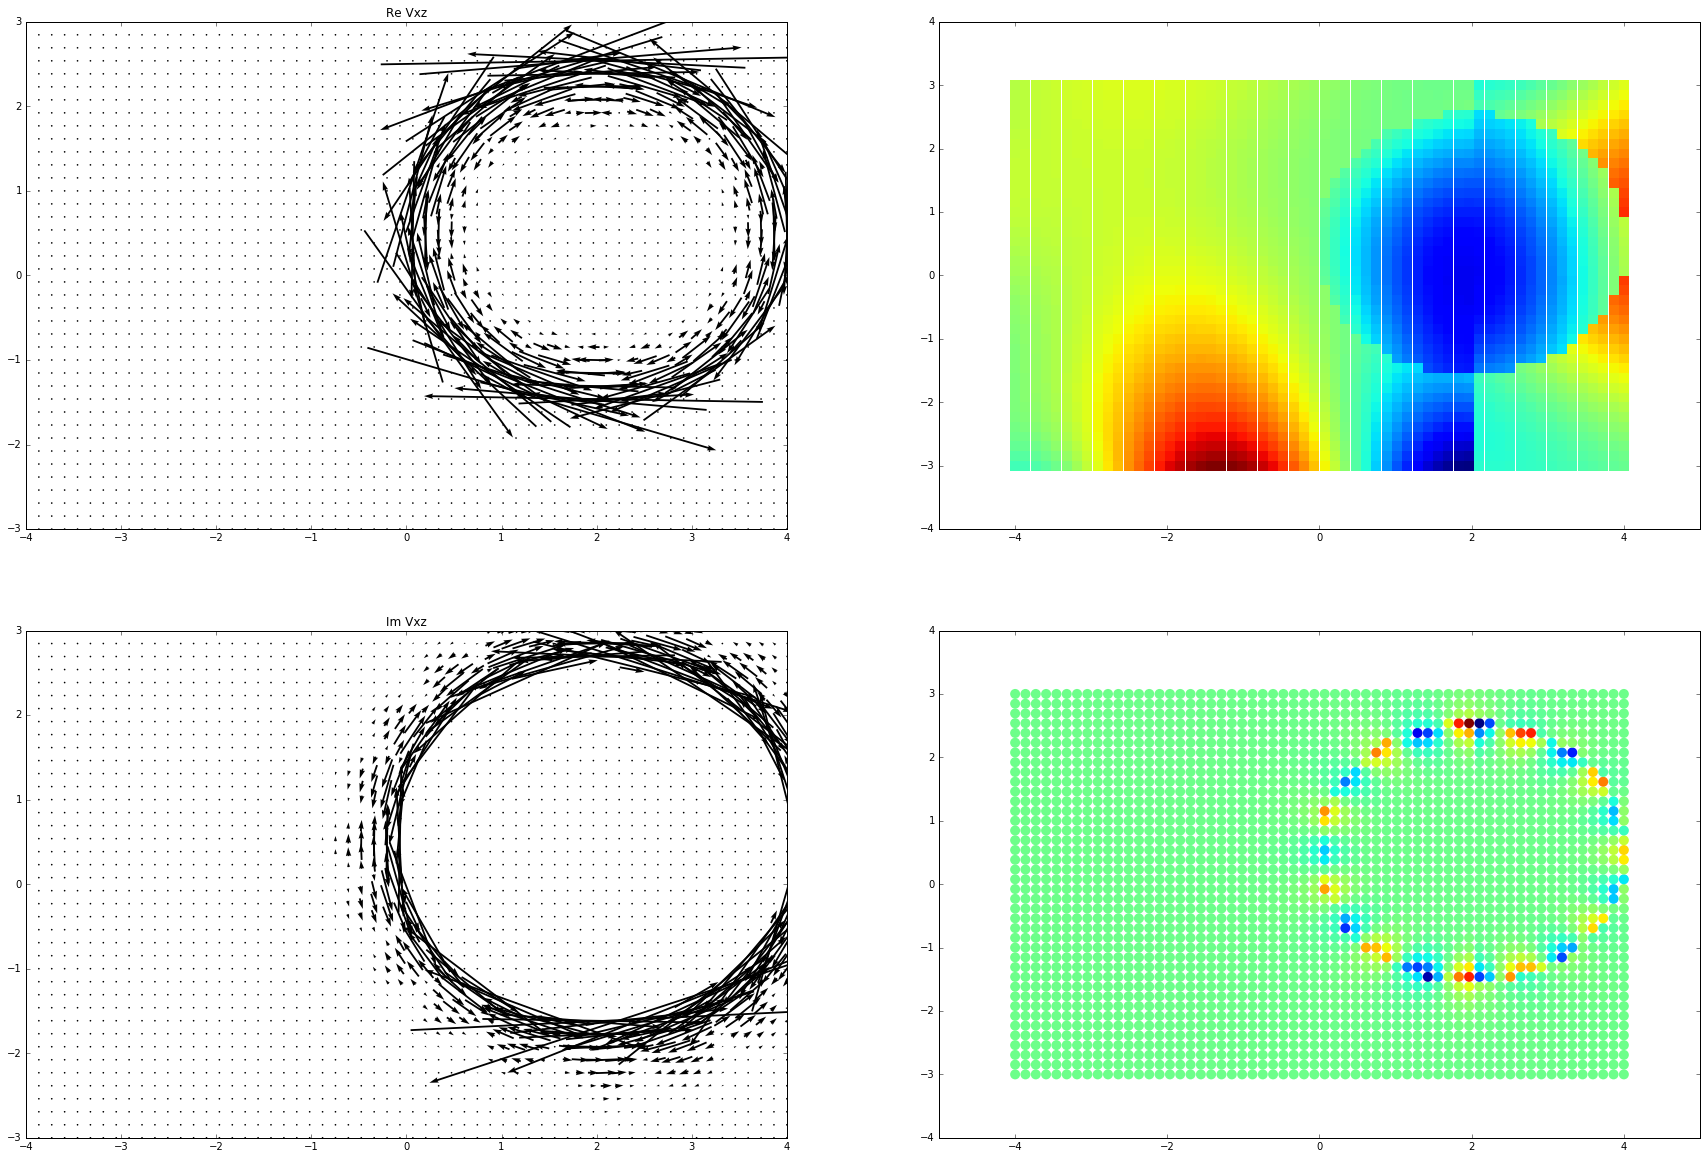

In [461]:
# Let's say we are decomposing M wave
x = np.linspace(-4,4,60)
y = 0
z = np.linspace(-3,3,40)
xj = x - l2j_cart[0]
yj = y - l2j_cart[1]
zj = z - l2j_cart[2]
x,y,z = np.meshgrid(x,y,z)
xj,yj,zj = np.meshgrid(xj,yj,zj)


# TODO udělat _funkce_ na řezy vln
Nrθ = np.empty(x.shape+(3,),dtype=complex)
cart = np.stack((x,y,z),axis=-1)
cartj = np.stack((xj,yj,zj),axis=-1)
sph = cart2sph(cart,axis=-1)
sphj = cart2sph(cartj,axis=-1)
print(x.shape)
for i in np.ndindex(x.shape):
    Nbase = np.empty((ll,3),dtype=complex)
    Mbase = np.empty((ll,3),dtype=complex)
    if(sphj[i][0]<dlj):
        for ii in range(ll):
            Nbase[ii]=svw_N(ms[ii], ns[ii], k, sphj[i+(0,)], sphj[i+(1,)], sphj[i+(2,)], J=1)    
            Mbase[ii]=svw_M(ms[ii], ns[ii], k, sphj[i+(0,)], sphj[i+(1,)], sphj[i+(2,)], J=1)
        Nrθ[i] = np.sum(Mbase[:,:]*Ain[:,ň],axis=0) + np.sum(Nbase[:,:]*Bin[:,ň],axis=0)
    else:
        for ii in range(ll):
            Nbase[ii]=svw_N(ms[ii], ns[ii], k, sphj[i+(0,)], sphj[i+(1,)], sphj[i+(2,)], J=J)    
            Mbase[ii]=svw_M(ms[ii], ns[ii], k, sphj[i+(0,)], sphj[i+(1,)], sphj[i+(2,)], J=J)
        Nrθ[i] = np.sum(Mbase[:,:]*Aout[:,ň],axis=0) + np.sum(Nbase[:,:]*Bout[:,ň],axis=0)
print(Nrθ.shape)
print("max|Re Vx| =",np.max(np.abs(np.real(Nrθ[...,0]))),
      "; max|Re Vy| =",np.max(np.abs(np.real(Nrθ[...,1]))),
      "; max|Re Vz| =",np.max(np.abs(np.real(Nrθ[...,2]))))
print("max|Im Vx| =",np.max(np.abs(np.imag(Nrθ[...,0]))),
      "; max|Im Vy| =",np.max(np.abs(np.imag(Nrθ[...,1]))),
      "; max|Im Vz| =",np.max(np.abs(np.imag(Nrθ[...,2]))))
#Nrθ = Nrθ * (np.amax(np.abs(Nrθ), axis=-1, keepdims=True) < 1000) # filter out the extremely from the plot
f, axarr = plt.subplots(2, 2, figsize=(30,20))
#plt.figure(figsize=(6, 4))
axarr[0,0].quiver(x.flatten(),z.flatten(),np.real(Nrθ[...,0]).flatten(),np.real(Nrθ[...,2]).flatten(),pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(x.flatten(),z.flatten(),s=100,edgecolors='none',c=np.real(Nrθ[...,1]).flatten(),marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(x.flatten(),z.flatten(),np.imag(Nrθ[...,0]).flatten(),np.imag(Nrθ[...,2]).flatten(),pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(x.flatten(),z.flatten(),s=100,edgecolors='none',c=np.imag(Nrθ[...,1]).flatten())



In [398]:
math.factorial(3)/math.factorial(60)

7.210682961895936e-82

In [414]:
xuE(5,5,1,1)

(494836.36363636295+0j)

In [417]:
(:)

SyntaxError: invalid syntax (<ipython-input-417-a843269e5806>, line 1)

In [427]:
lpmn(-3,3,0.8)

(array([[ 1.    ,  0.8   ,  0.46  ,  0.08  ],
        [ 0.    ,  0.3   ,  0.24  ,  0.165 ],
        [ 0.    ,  0.    ,  0.045 ,  0.036 ],
        [ 0.    ,  0.    ,  0.    ,  0.0045]]),
 array([[ 0.        ,  1.        ,  2.4       ,  3.3       ],
        [ 0.        , -0.66666667, -0.23333333,  0.23333333],
        [ 0.        ,  0.        , -0.2       , -0.115     ],
        [ 0.        ,  0.        ,  0.        , -0.03      ]]))

In [428]:
C = np.empty((3,2,4))

In [432]:
C[1,:,1]=np.array([10,20,3])

ValueError: could not broadcast input array from shape (3) into shape (2)

In [431]:
C

array([[[   0.        ,    0.        ,    0.        ,    1.        ],
        [   1.25      ,    0.        ,    2.34260643,    1.05417289]],

       [[  -4.68521286,   10.        ,   -3.47560976,  -12.43902439],
        [   2.47592549,   20.        ,   -6.28504164,    0.50862582]],

       [[ -20.60157644,   38.85187388,   -2.09733651,  -21.42941386],
        [ 130.91281849,   -4.14184356,   -9.38211866,  234.17158776]]])

In [441]:
sph_pos = np.array([2,0.4,0])
ms,ns = mnindex(4)
SVWF_base(sph_pos, ms, ns, coord_axis = -1, J=1)

[ 0.45464871  0.43539777  0.19844795  0.0607221   0.01407939] [-0.43539777  0.01925094  0.13772585  0.07700375  0.02552362]


TypeError: 'int' object is not subscriptable